# Introduction to LDA and data cleaning
In this notebook, we introduce LDA and what we need for our model. We then proceed to load and clean a sample of the NOW corpus to fulfill our needs.

## What is LDA
[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a statistical model which we will use for topic modelling/discovery. LDA will, given a list of words belonging to a text, output the topics present and their probability. In here, a topic is represented as a probability distribution of words. Thus each text/document will be a distribution over the topics. In short, texts have an associated topic distribution and topics have a word distribution. 

The image below is the plate notation for LDA, where:
* θ<sub>m</sub> is the topic distribution for document m,
* φ<sub>k</sub> is the word distribution for topic k,
* z<sub>mn</sub> is the topic for the n-th word in document m, and
* w<sub>mn</sub> is the specific word.
* α is the parameter of the Dirichlet prior on the per-document topic distributions,
* β is the parameter of the Dirichlet prior on the per-topic word distribution,

![](LDA.png)

α and β are the parameters for the model. A big α means that documents are likely to be represented by a high number of topics and vice versa. Same goes for β, a high value meaning that topics are represented by a hign number of words. The number of topics that LDA outputs is dependent on our input and works a bit like clustering. If we allow too many topics we might end up splitting topics uselessly and a too few will make us group them unnecessarily. 

## The NOW corpus
This notebook shows the cleaning process that will be used for the ADA project. Here, only a sample of the data is used (from [here](https://www.corpusdata.org/now_corpus.asp)), but the methods should be the same once scaled to the full database available on the cluster.

The NOW database is composed of billions of words from online newspapers and magazines from 20 different countries. The data we downloaded comes in different files which can be used together or independently. These files are:

1. **now-samples-lexicon.txt**: this is the full dictionnary of the english language, a lexicon. It contains four clolumns, `wID` which is the word id, `word` the actual word, `lemma` which is family of the word (ie: if word is "walked", lemma is "walk") and `PoS` which is the part of speech.
2. **now-samples_sources.txt**: this is the source of every text, in order it contains the text id, the number of words, the date, the country, the website, the url and title of the article.
3. **text.txt**: this file has the complete texts of the articles, the first column is the `textID` in the format @@textID, the second column is the full text, complete with html paragraphs and headers. It is important to note that to prevent plagiarism, every 200 words, 10 words are replaced by the string "@ @ @ @ @ @ @ @ @ @". Combined words are also split, example "can't" is written as "ca n't" and punctuation is surrounded by spaces.
4. **wordLemPoS.txt**: finally, this file contains the `word`, `lemma` and `PoS` for each word in the texts, one by one, so one could read the texts by reading down the columns. Along with that is the `textID` from where the word is and an `ID (seq)` which is a unique indetifier for each word in the database. Each time a word is added this number is incremented.

## What we need from the NOW corpus for LDA
The model will take two inputs, a matrix with all the important words for each text, and a list of all the important words. By important, it is meant the words which will give us good topic modelling. For example, names, locations, simple words like "but, "I" or "and" will not give meaningfull results and are quite common in english (so-called stopwords). Other common words present in our database should be removed too. We also should use lemmas instead of words.

Therefore, the file `wordLemPoS.txt` (hence referred as wlp) is the most important here as it lists all the lemmas with their `textID` associated. Which means that with it we can lsit all the lemmas, remove those we do not want to make our word list, but also group them by texts to create our text-word matrix.

We will also need `now-sample_sources.txt` (hence referred as sources) to link the texts with the information we will deem useful. For example country, date or website.

These are thus the two file we will import and process here with the sample data but also those we will use with the data on the cluster.

## Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

import re
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

from pyspark.mllib.clustering import LDA, LDAModel

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Wlp processing


The goal of this part is to extract the useful data from wlp text files. Since they contain all the words of all the articles and the lemmas to replace them with.

In [15]:
#read the text file and remove the first three rows (zip trick)
wlp_rdd = sc.textFile('sample_data/wordLem_poS.txt').zipWithIndex().filter(lambda r: r[1] > 2).keys()

In [28]:
#we split the elements separated by tabs
lines = wlp_rdd.map(lambda r: r.split('\t'))

#identify the columns
wlp_schema = lines.map(lambda r: Row(textID=int(r[0]),idseq=int(r[1]),word=r[2],lemma=r[3],pos=r[4]))
wlp = spark.createDataFrame(wlp_schema)
wlp.show(5)

+----------+------+----+------+-------+
|     idseq| lemma| pos|textID|   word|
+----------+------+----+------+-------+
|1095362496|      |  fo| 11241|@@11241|
|1095362497|      |null| 11241|    <p>|
|1095362498|   sol| np1| 11241|    Sol|
|1095362499|yurick| np1| 11241| Yurick|
|1095362500|      |   ,| 11241|      ,|
+----------+------+----+------+-------+
only showing top 5 rows



### Word selection
It is very important to select the right words and the right number. The ocncept of "garbage in garbage out" has never been more true than with LDA. When we analyse a text we focus on certain words to extract it's meaning and topic. The same is true here since words like if, for, numbers, common names are not that useful.

Here, we provide and example of the process we will go through. However this is not really a data cleaning step as it will directly influence our model. It is more of a model preprocessing step. We will surely go through many iterations of this next part for our model to give the best results. 

First of all, we can remove all the words which have a PoS which do not interest us. For example number (`mc`,`mc1`,`m#`) or punctuation (`.`,`'`), etc...

Details:
1. `.`,`,`,`'`, `"` are punctuations
2. `null` are html tags from the websites
3. `mc`,`mc1`, `m#` are various numbers and ; thus we remove all PoS starting with m
3. `fo`, `fu`, `fw` are random non sensical words, foreign words; thus we remove all PoS starting with f

In [18]:
pos_remove = ['.',',',"\'",'\"','null']
wlp_nopos = wlp.filter(~wlp['pos'].isin(pos_remove)).filter(~wlp['pos'].startswith('m')).filter(~wlp['pos'].startswith('f')).drop('idseq','pos','word')

Now, we load our list of stopwords, the words that we are not going to use in LDA as they are too common or are proper nouns. We can also remove the rows with no lemmas or those with lemmas that don't make sense or are not common enough.

In [20]:
#np.save('our_stopwords',stopwords)
stopwords = sc.textFile('our_stopwords.txt').collect()
print('Number of stopwords: ', len(stopwords))

Number of stopwords:  5639


In [21]:
#filter out stopwords and looking at the frequency of words without them
wlp_nostop = wlp_nopos.filter(~wlp['lemma'].isin(stopwords))
lemma_freq = wlp_nostop.groupBy('lemma').count().sort('count', ascending=False)
lemma_freq.show()

+----------+-----+
|     lemma|count|
+----------+-----+
|      year| 4272|
|      time| 3169|
|    people| 2913|
|      take| 2667|
|       use| 2244|
|      work| 2137|
|       day| 1819|
|     state| 1713|
|   company| 1698|
|   comment| 1667|
|      need| 1654|
|      want| 1579|
|      look| 1564|
|     world| 1553|
|government| 1551|
|      show| 1480|
|      give| 1480|
|   country| 1465|
|      find| 1464|
|     right| 1408|
+----------+-----+
only showing top 20 rows



We will also remove the most common and least common lemmas. These will be useless since they won't provide enough information for our LDA analysis. Here, we filter out the top 1% and bottom 80% of all lemmas.

<div class="alert alert-success">
Maybe should change from percentile to number for bottom filtering, depending on which one is the harshest (in here it is number)
</div>

In [23]:
#calculate percentiles and filtering out the lemmas above and below them
[bottom,top] = lemma_freq.approxQuantile('count', [0.8,0.99], 0.01)
lemma_tokeep = lemma_freq.filter(lemma_freq['count']>bottom).filter(lemma_freq['count']<top)
c = lemma_tokeep.count()
print('Number of lemmas left: %d'%c)
print('Percentage of lemmas left: %.2f'%(c/lemma_freq.count()*100))

Number of lemmas left: 7336
Percentage of lemmas left: 18.86


Making a inner join, we keep only the words which are in both lists! In the end, we can group the lemmas in their texts to create our text-word matrix.

In [39]:
#perform sql query and inner join
wlp_nostop.registerTempTable('wlp_nostop')
lemma_tokeep.registerTempTable('lemma_tokeep')

query = """
SELECT wlp_nostop.lemma, wlp_nostop.textID
FROM wlp_nostop
INNER JOIN lemma_tokeep ON wlp_nostop.lemma = lemma_tokeep.lemma
"""

wlp_kept = spark.sql(query)
wlp_bytext = wlp_kept.groupBy('textID').agg(collect_list('lemma'))\
                    .sort('textID')\
                    .withColumnRenamed('collect_list(lemma)','lemma_list')
wlp_bytext.show()

+------+--------------------+
|textID|          lemma_list|
+------+--------------------+
| 11241|[film, film, film...|
| 11242|[online, happen, ...|
| 11243|[dough, dough, do...|
| 11244|[trail, launch, o...|
| 21242|[online, launch, ...|
| 21243|[recognize, indic...|
| 31240|[recognize, inten...|
| 31241|[online, online, ...|
| 31242|[settlement, sett...|
| 41240|[explain, hometow...|
| 41241|[scale, lack, pre...|
| 41244|[everyday, trail,...|
| 51243|[australia, austr...|
| 61240|[frustrate, inten...|
| 61242|[editor-in-chief,...|
| 71240|[indicator, requi...|
| 71241|[likelihood, requ...|
| 71242|[film, film, char...|
| 71243|[online, staff, s...|
| 71244|[bone, leakey, le...|
+------+--------------------+
only showing top 20 rows



In [38]:
wlp_kept = wlp_nostop.join(lemma_tokeep,'lemma','inner')
wlp_bytext = wlp_kept.groupBy('textID').agg(collect_list('lemma'))\
                    .sort('textID')\
                    .withColumnRenamed('collect_list(lemma)','lemma_list')
wlp_bytext.show()

+------+--------------------+
|textID|          lemma_list|
+------+--------------------+
| 11241|[film, film, film...|
| 11242|[online, happen, ...|
| 11243|[dough, dough, do...|
| 11244|[trail, launch, o...|
| 21242|[online, launch, ...|
| 21243|[recognize, indic...|
| 31240|[recognize, inten...|
| 31241|[online, online, ...|
| 31242|[settlement, sett...|
| 41240|[explain, hometow...|
| 41241|[scale, lack, pre...|
| 41244|[everyday, trail,...|
| 51243|[australia, austr...|
| 61240|[frustrate, inten...|
| 61242|[editor-in-chief,...|
| 71240|[indicator, requi...|
| 71241|[likelihood, requ...|
| 71242|[film, film, char...|
| 71243|[online, staff, s...|
| 71244|[bone, leakey, le...|
+------+--------------------+
only showing top 20 rows



In [31]:
wlp_bytext.count()

2914

## Sources
Contains all the additional informations about each text.

In [13]:
sources_rdd = sc.textFile('sample_data/now-samples-sources.txt')\
                .map(lambda r: r.split('\t'))

header = sources_rdd.take(3)
sources_rdd = sources_rdd.filter(lambda l: l != header[0])\
                .filter(lambda l: l != header[1])\
                .filter(lambda l: l != header[2])

In [14]:
#create schema and change data type for date
sources_schema = sources_rdd.map(lambda r: Row(textID=int(r[0]),nwords=int(r[1]),date=r[2],country=r[3],website=r[4],url=r[5],title=r[6],)) 
sources = spark.createDataFrame(sources_schema)
sources = sources.withColumn('date',to_date(sources.date, 'yy-MM-dd'))

In [15]:
sources.printSchema()

root
 |-- country: string (nullable = true)
 |-- date: date (nullable = true)
 |-- nwords: long (nullable = true)
 |-- textID: long (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- website: string (nullable = true)



In [16]:
sources.show(5)

+-------+----------+------+------+--------------------+--------------------+-------------------+
|country|      date|nwords|textID|               title|                 url|            website|
+-------+----------+------+------+--------------------+--------------------+-------------------+
|     US|2013-01-06|   397| 11241|Author of The War...|http://kotaku.com...|             Kotaku|
|     US|2013-01-06|   757| 11242|That's What They ...|http://michiganra...|     Michigan Radio|
|     US|2013-01-06|   755| 11243|Best of New York:...|http://www.nydail...|New York Daily News|
|     US|2013-01-06|  1677| 11244|Reflecting on a q...|http://www.oregon...|     OregonLive.com|
|     US|2013-01-11|   794| 21242|Ask Ars: Does Fac...|http://arstechnic...|       Ars Technica|
+-------+----------+------+------+--------------------+--------------------+-------------------+
only showing top 5 rows



In [29]:
countries = sources.toPandas().country.value_counts()

## LDA
This is an expanded version on parrot's LDA using spark only.

In [42]:
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.ml.feature import Normalizer
#from pyspark.mllib.linalg import Vectors

Can set certain filtering with CountVectorizer, not sure if that's useful since we already do that before hand.

In [43]:
NPARTITION

8

In [44]:
cvmodel = CountVectorizer(inputCol="lemma_list", outputCol="raw_features").fit(wlp_bytext)
result_cv = cvmodel.transform(wlp_bytext).drop('lemma_list').repartition(NPARTITION,'textID').persist()
result_cv.show()

In [47]:
idfModel = IDF(inputCol="raw_features", outputCol="non_norm_features").fit(result_cv)
result_tfidf = idfModel.transform(result_cv).drop('lemma_list','raw_features')
result_tfidf.show()

In [50]:
norm = Normalizer(inputCol="non_norm_features", outputCol="features")
tfidf_norm = norm.transform(result_tfidf).drop('non_norm_features')

In [32]:
#spliting the test and training set 
split = result_tfidf.randomSplit([0.8,0.2])
train = split[0]
test = split[1]

In [45]:
%%time
lda_model = LDA(k=20, maxIter=100).fit(train) #uses col features by default but just to be sure and explain better
lda_model.logPerplexity(test)

8.802845980353812

In [56]:
# Describe topics
result_lda = lda_model.transform(result_tfidf)
topics = lda_model.describeTopics()
words_topics = topics.toPandas().termIndices
weight_topics = topics.toPandas().termWeights
voc = cvmodel.vocabulary

## Postprocessing

In [41]:
with open('topics.txt','w') as txt:
    for t in range(len(words_topics)):
        txt.write('Topic {}:\n'.format(t))
        for w in range(len(voc[words_topics[t]])):
            line = '%.4f*%s + '%(weight_topics[t][w],voc[words_topics[t][w]])
            if words_topics[t][-1]==words_topics[t][w]: line = '%.4f*%s'%(weight_topics[t][w],voc[words_topics[t][w]])
            txt.write(line)
        txt.write('\n')

with open('topics.txt','r') as txt:
    for line in txt:
        print(line)

Topic 0:

0.0152*farm + 0.0122*farmer + 0.0096*dairy + 0.0091*park + 0.0087*tree + 0.0080*building + 0.0079*burger + 0.0078*lobster + 0.0071*council + 0.0070*christmas

Topic 1:

0.0059*canada + 0.0052*site + 0.0051*technology + 0.0051*customer + 0.0047*user + 0.0046*product + 0.0045*service + 0.0045*online + 0.0044*school + 0.0042*network

Topic 2:

0.0193*marino + 0.0151*colombia + 0.0114*indian + 0.0105*recommend + 0.0105*web + 0.0098*delhi + 0.0087*comment + 0.0077*city + 0.0075*rape + 0.0073*tiger

Topic 3:

0.0157*gripper + 0.0117*solar + 0.0083*uninsured + 0.0081*magnetic + 0.0080*garbage + 0.0080*electric + 0.0077*chem + 0.0075*dress + 0.0075*fiat + 0.0073*pielke

Topic 4:

0.0166*microsoft + 0.0096*lg + 0.0084*samsung + 0.0081*device + 0.0079*hariri + 0.0072*sparta + 0.0072*app + 0.0071*rating + 0.0070*lake + 0.0066*version

Topic 5:

0.0112*club + 0.0093*sentence + 0.0088*league + 0.0088*football + 0.0083*court + 0.0076*guilty + 0.0076*player + 0.0063*prison + 0.0060*manchest

In [223]:
topic_source_bytext = sources.join(result_lda,'textID','inner').drop('url','web','website','lemma_list','raw_features','features').sort('textID')
topic_source_bytext.show()

+------+-------+----------+------+--------------------+--------------------+
|textID|country|      date|nwords|               title|   topicDistribution|
+------+-------+----------+------+--------------------+--------------------+
| 11241|     US|2013-01-06|   397|Author of The War...|[1.28422505531488...|
| 11242|     US|2013-01-06|   757|That's What They ...|[1.08891097726467...|
| 11243|     US|2013-01-06|   755|Best of New York:...|[7.68289358331195...|
| 11244|     US|2013-01-06|  1677|Reflecting on a q...|[3.60786135300145...|
| 21242|     US|2013-01-11|   794|Ask Ars: Does Fac...|[9.69791932332789...|
| 21243|     US|2013-01-11|   690|Accused associate...|[6.87751441501654...|
| 31240|     IE|2013-01-16|   701|Olympic star Conl...|[9.69006522196058...|
| 31241|     IE|2013-01-16|   336|Shakira launches ...|[1.83307816215161...|
| 31242|     IE|2013-01-16|   262|Declan Ganley for...|[2.00487900777354...|
| 41240|     US|2013-01-22|   764|Rape A 'Significa...|[7.82305362400763...|

## Some fun

In [31]:
plt.rcParams['figure.figsize'] = 12, 8

In [224]:
tst_pd = topic_source_bytext.toPandas().set_index('textID')
tst_pd.head()

,country,date,nwords,title,topicDistribution
textID,,,,,
11241,US,2013-01-06,397,"Author of The Warriors, Cult Film Adapted to H...","[0.00012842250553178413, 0.40537235071153876, ..."
11242,US,2013-01-06,757,That's What They Say: Dialect Society chooses ...,"[0.00010889109772676762, 0.11799241690229713, ..."
11243,US,2013-01-06,755,Best of New York: Croissant,"[7.682893583281508e-05, 0.33209947166024273, 0..."
11244,US,2013-01-06,1677,Reflecting on a quarter-century of growth in P...,"[3.607861353013238e-05, 0.9181909885086931, 0...."
21242,US,2013-01-11,794,Ask Ars: Does Facebook auto-delete content aft...,"[9.697919323339782e-05, 0.1895968293727808, 0...."


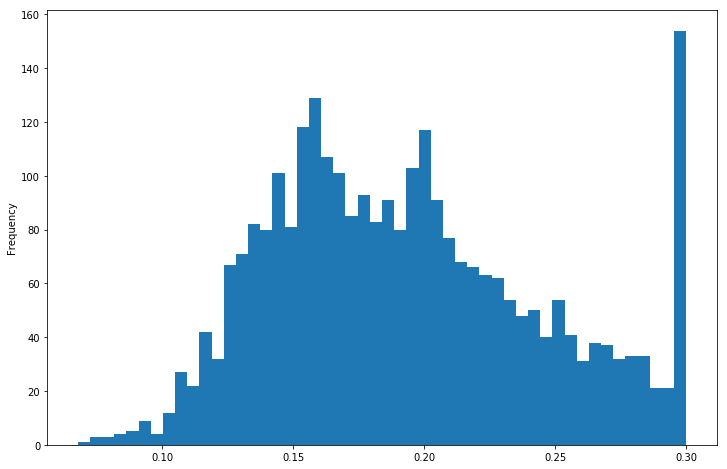

In [225]:
tst_pd.apply(lambda r: np.std(r.topicDistribution),axis=1).plot.hist(bins=50)

We will need to find a way of selecting the topic. The trivial way is to take the one with the maximum weight but this would be disregarding the other topics and their weights. So we can chose only those above a certain threshold, or choose the max only if the std is high enough.

In [226]:
def selectTopic(distr,threshold):
    #suitable max-threshold are from 0 to 1
    #suitable std-threshold are from 0 to 0.3 (maybe a problem)
    if np.std(distr)>=threshold:
        return np.argmax(distr)
    return -999

In [227]:
list_thres = np.linspace(0,0.3,50)
count = []
for t in list_thres:
    count.append(np.count_nonzero(tst_pd.apply(lambda r: selectTopic(r.topicDistribution,t),axis=1)==-999))

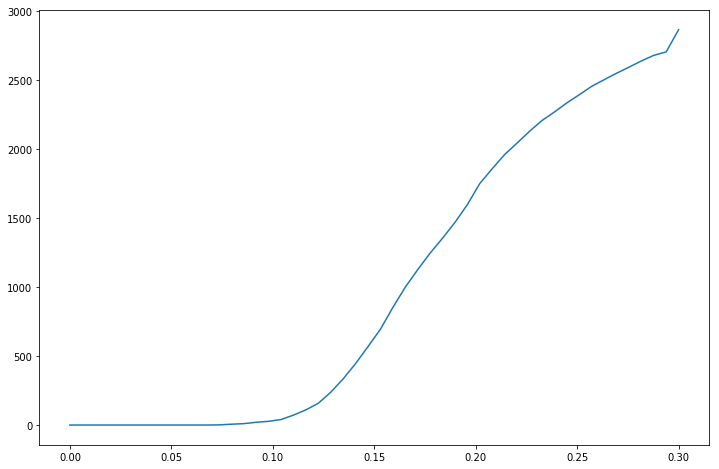

In [228]:
plt.plot(list_thres,count)